Build CNN Classifier using Simulation data and test it using real images
==============================================================

Get Train and Test data using the simulation
----------------------------------------------



<div class="alert alert-block alert-info">
This section of the tutorial assumes that you have a functional ISAAC simulation working.
If not, you'll have to use pre-generated data for this tutorial purpose (not recommended).
</div>

Start the simulation:

`roslaunch isaac sim.launch gzclient:=true pose:="10.5 -8 4.5 0 0 0 1"`

Spawn the object

`roslaunch isaac_gazebo spawn_object.launch spawn:=sock`

Add an object to the simulation to be the anomaly (in this case a sock):

`rosrun img_analysis get_train_data -path_dataset $PATH_DATASET -vent_poses $VENT_POSES -other_poses $OTHER_POSES [OPTIONS]`

Arguments:
 - `path_dataset`        - Path to where to save the datasets, mandatory to define.
 - `vent_poses`          - *.txt* file containing the vent poses
 - `other_poses`         - *.txt* file containing the other non-vent poses
 - `robot_dist`          - Robot's distance to vent, standard is 1m
 - `train_pics_per_vent` - Number of pictures taken per vent/other for train data
 - `test_pics_per_vent`  - Number of pictures taken per vent/other for test data
 
 
 


Train CNN
-----------

In [1]:

# Parameters
data_dir = "/src/data/vent/Second_run"  # specify data path
classes = ["free", "obstacle", "unknown"]  # specify the image classes
num_epochs = 30  # number of epochs to train
model_name = "model_cnn.pt"  # saved model name
trace_model_name = "traced_model_cnn.pt"  # saved traced model name

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from torch import nn, optim
from torchvision import datasets, models, transforms

torch.cuda.is_available()

True

In [3]:
# Define transforms for the training data and testing data
train_transforms = transforms.Compose(
    [
        transforms.Resize([256, 256]),
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + "/train", transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + "/test", transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

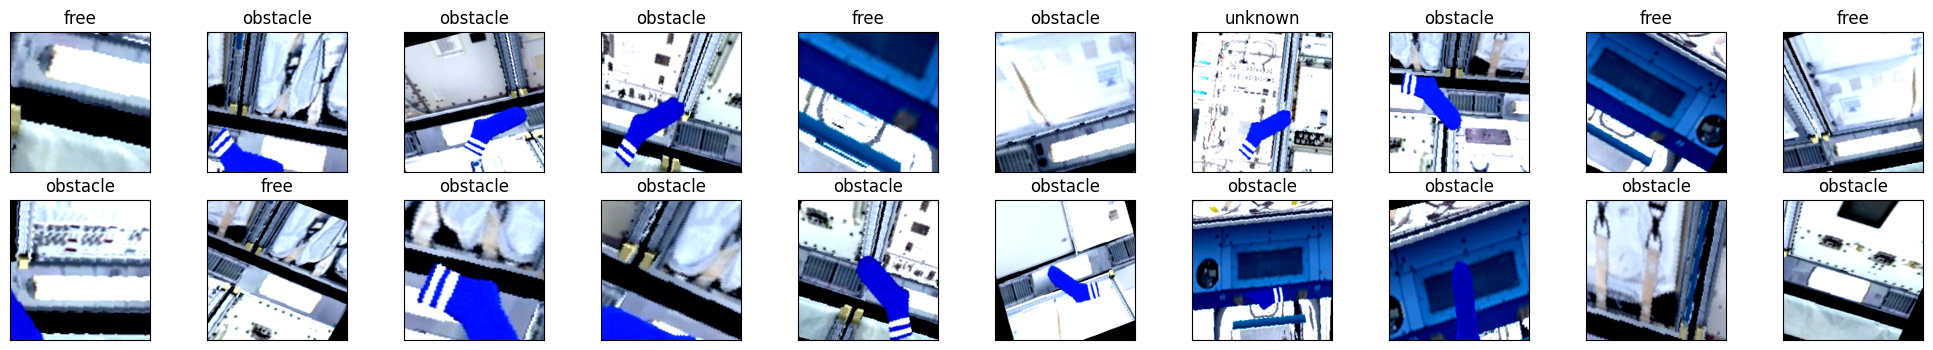

In [4]:

# Visualize some of the data-----------------------
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image


# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy()  # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])


In [5]:

# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 3),
    nn.LogSoftmax(dim=1),
)

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:02<00:00, 11.4MB/s]


In [6]:

model.to(device)

epochs = num_epochs
steps = 0
running_loss = 0
print_every = 5
test_loss_min = np.Inf
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)

                    test_loss += batch_loss.item()

                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            print(
                "Epoch ",
                epoch + 1,
                "/",
                epochs,
                ".. " "Train loss: ",
                running_loss / print_every,
                ".. " "Test loss: ",
                test_loss / len(testloader),
                ".. " "Test accuracy: ",
                accuracy / len(testloader),
                "",
            )
            running_loss = 0

            # save model if validation loss has decreased
            if test_loss <= test_loss_min:
                torch.save(model.state_dict(), model_name)
                test_loss_min = test_loss

                model.to("cpu")
                # An example input you would normally provide to your model's forward() method.
                example = torch.rand(1, 3, 224, 224)
                # Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
                traced_script_module = torch.jit.trace(model, example)
                output = traced_script_module(torch.ones(1, 3, 224, 224))
                print(output)
                traced_script_module.save(trace_model_name)
                model.to(device)

            model.train()


Epoch  1 / 30 .. Train loss:  1.2671339631080627 .. Test loss:  1.0124075412750244 .. Test accuracy:  0.4641262888908386 
tensor([[-1.2351, -0.7102, -1.5250]], grad_fn=<LogSoftmaxBackward0>)
Epoch  2 / 30 .. Train loss:  0.9305944323539734 .. Test loss:  0.8238682448863983 .. Test accuracy:  0.5953443944454193 
tensor([[-0.8511, -1.0874, -1.4440]], grad_fn=<LogSoftmaxBackward0>)
Epoch  3 / 30 .. Train loss:  0.7588722348213196 .. Test loss:  0.7243848145008087 .. Test accuracy:  0.7184311151504517 
tensor([[-0.7477, -1.0669, -1.7012]], grad_fn=<LogSoftmaxBackward0>)
Epoch  4 / 30 .. Train loss:  0.68133065700531 .. Test loss:  0.5958039462566376 .. Test accuracy:  0.8864795863628387 
tensor([[-0.8163, -1.1572, -1.4122]], grad_fn=<LogSoftmaxBackward0>)
Epoch  5 / 30 .. Train loss:  0.5557424843311309 .. Test loss:  0.5495979189872742 .. Test accuracy:  0.8691007792949677 
tensor([[-0.5930, -1.3357, -1.6909]], grad_fn=<LogSoftmaxBackward0>)
Epoch  5 / 30 .. Train loss:  0.513420575857162

Validate Result using Real data
------------------------------

To validate the results using real data, let's use an image collected during ISS operations

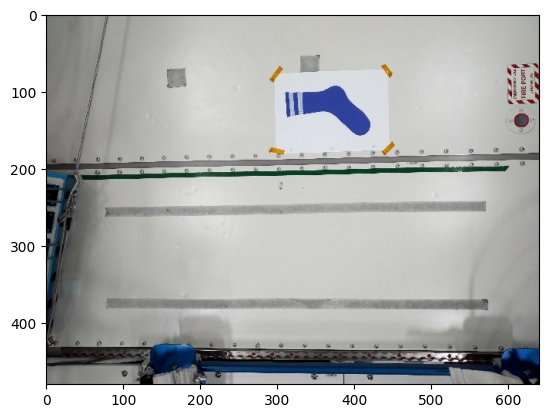

Classification:  obstacle


In [7]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from torch import nn, optim
from torchvision import datasets, models, transforms

# Open and display image
image = Image.open("/src/data/vent/sock_iss.jpg")
imgplot = plt.imshow(image)
plt.show()

# Open model
model = models.densenet121(pretrained=True)
model.classifier = nn.Sequential(
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 3),
    nn.LogSoftmax(dim=1),
)
model.load_state_dict(torch.load("model_cnn.pt"))
model.eval()

# Classify Image!
test_transforms = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
image_tensor = test_transforms(image).float()
image_tensor = image_tensor.unsqueeze_(0)
output = model(image_tensor)

# Print Result
_, predicted = torch.max(output, 1)
print("Classification: ", classes[predicted])
